<a href="https://colab.research.google.com/github/UBGidado/My_Research/blob/Notebooks/DialogRE_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !pip install transformers datasets

### Imports

In [ ]:
import json
import torch
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from transformers import AutoTokenizer
from datasets import Dataset, Value, ClassLabel, Features
from collections import Counter, defaultdict
import re
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords


### Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/MyDrive/My Research/dialogre/data_v2/en/data"

train_file = f"{data_path}/train.json"
dev_file = f"{data_path}/dev.json"
test_file = f"{data_path}/test.json"

#Load from JSON data
def load_dialogre_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

Mounted at /content/drive


In [ ]:
train_data = load_dialogre_data(train_file)
dev_data = load_dialogre_data(dev_file)
test_data = load_dialogre_data(test_file)

print(f"Train dialogues: {len(train_data)}")
print(f"Dev dialogues: {len(dev_data)}")
print(f"Test dialogues: {len(test_data)}")
print("---------------------------------")
print("An entry of train_data:")
display(train_data[0])

Train dialogues: 1073
Dev dialogues: 358
Test dialogues: 357
---------------------------------
An entry of train_data:


[["Speaker 1: It's been an hour and not one of my classmates has shown up! I tell you, when I actually die some people are gonna get seriously haunted!",
  'Speaker 2: There you go! Someone came!',
  "Speaker 1: Ok, ok! I'm gonna go hide! Oh, this is so exciting, my first mourner!",
  'Speaker 3: Hi, glad you could come.',
  'Speaker 2: Please, come in.',
  "Speaker 4: Hi, you're Chandler Bing, right? I'm Tom Gordon, I was in your class.",
  'Speaker 2: Oh yes, yes... let me... take your coat.',
  "Speaker 4: Thanks... uh... I'm so sorry about Ross, it's...",
  'Speaker 2: At least he died doing what he loved... watching blimps.',
  'Speaker 1: Who is he?',
  'Speaker 2: Some guy, Tom Gordon.',
  "Speaker 1: I don't remember him, but then again I touched so many lives.",
  'Speaker 3: So, did you know Ross well?',
  "Speaker 4: Oh, actually I barely knew him. Yeah, I came because I heard Chandler's news. D'you know if he's seeing anyone?",
  'Speaker 3: Yes, he is. Me.',
  'Speaker 4: 

## Data Inspection

In [ ]:
def inspect_dialogue(data, dialogue_idx=0):
    """Inspect a specific dialogue"""
    dialogue = data[dialogue_idx]
    turns = dialogue[0]  # dialogue turns
    instances = dialogue[1]  # relation instances

    print(f"=== Dialogue {dialogue_idx} ===")
    print(f"Number of turns: {len(turns)}")
    print(f"Number of relation instances: {len(instances)}")

    print("\n--- Dialogue Turns ---")
    for i, turn in enumerate(turns):
        print(f"Turn {i+1}: {turn}")

    print("\n--- Relation Instances ---")
    for i, instance in enumerate(instances):
        print(f"Instance {i+1}:")
        print(f"  Argument 1 (x): {instance['x']} (type: {instance['x_type']})")
        print(f"  Argument 2 (y): {instance['y']} (type: {instance['y_type']})")
        print(f"  Relations: {instance['r']}")
        print(f"  Relation IDs: {instance['rid']}")
        print(f"  Triggers: {instance['t']}")
        print()

# Inspect first dialogue from train set
inspect_dialogue(train_data, 5)

=== Dialogue 5 ===
Number of turns: 7
Number of relation instances: 4

--- Dialogue Turns ---
Turn 1: Speaker 1: Hey Pheebs.
Turn 2: Speaker 2: Hey!
Turn 3: Speaker 1: Any sign of your brother?
Turn 4: Speaker 2: No, but he's always late.
Turn 5: Speaker 1: I thought you only met him once?
Turn 6: Speaker 2: Yeah, I did. I think it sounds y'know big sistery, y'know, 'Frank's always late.'
Turn 7: Speaker 1: Well relax, he'll be here.

--- Relation Instances ---
Instance 1:
  Argument 1 (x): Speaker 2 (type: PER)
  Argument 2 (y): Pheebs (type: PER)
  Relations: ['per:alternate_names']
  Relation IDs: [30]
  Triggers: ['']

Instance 2:
  Argument 1 (x): Speaker 2 (type: PER)
  Argument 2 (y): Frank (type: PER)
  Relations: ['per:siblings']
  Relation IDs: [16]
  Triggers: ['brother']

Instance 3:
  Argument 1 (x): Frank (type: PER)
  Argument 2 (y): Speaker 2 (type: PER)
  Relations: ['per:siblings']
  Relation IDs: [16]
  Triggers: ['brother']

Instance 4:
  Argument 1 (x): Speaker 1 (

## Extract all unique relations and analyze them


In [ ]:
def analyze_relation_types(train_data, dev_data, test_data):
    """Analyze all relation types across datasets"""

    # Collect all relations from all datasets
    all_relations = []
    relation_counts = Counter()
    dataset_relation_counts = {'train': Counter(), 'dev': Counter(), 'test': Counter()}

    datasets = {'train': train_data, 'dev': dev_data, 'test': test_data}

    for dataset_name, data in datasets.items():
        for dialogue in data:
            instances = dialogue[1]  # relation instances
            for instance in instances:
                for relation in instance['r']:
                    all_relations.append(relation)
                    relation_counts[relation] += 1
                    dataset_relation_counts[dataset_name][relation] += 1

    unique_relations = list(set(all_relations))
    print(f"Total unique relation types found: {len(unique_relations)}")

    return unique_relations, relation_counts, dataset_relation_counts

# Run the analysis
unique_relations, relation_counts, dataset_relation_counts = analyze_relation_types(train_data, dev_data, test_data)

Total unique relation types found: 37


## Display all 36 relation types


In [ ]:
print("All DialogRE Relation Types:")
print("="*50)

# Sort relations alphabetically for better readability
sorted_relations = sorted(unique_relations)

for i, relation in enumerate(sorted_relations, 1):
    total_count = relation_counts[relation]
    train_count = dataset_relation_counts['train'][relation]
    dev_count = dataset_relation_counts['dev'][relation]
    test_count = dataset_relation_counts['test'][relation]

    print(f"{i:2d}. {relation:<25} | Total: {total_count:4d} | Train: {train_count:4d} | Dev: {dev_count:3d} | Test: {test_count:3d}")

All DialogRE Relation Types:
 1. gpe:births_in_place       | Total:    1 | Train:    0 | Dev:   1 | Test:   0
 2. gpe:residents_of_place    | Total:   83 | Train:   48 | Dev:  12 | Test:  23
 3. gpe:visitors_of_place     | Total:   92 | Train:   48 | Dev:  19 | Test:  25
 4. org:employees_or_members  | Total:   72 | Train:   45 | Dev:  11 | Test:  16
 5. org:students              | Total:    8 | Train:    5 | Dev:   2 | Test:   1
 6. per:acquaintance          | Total:   70 | Train:   26 | Dev:  10 | Test:  34
 7. per:age                   | Total:   78 | Train:   53 | Dev:  15 | Test:  10
 8. per:alternate_names       | Total: 2148 | Train: 1329 | Dev: 413 | Test: 406
 9. per:alumni                | Total:  186 | Train:  114 | Dev:  38 | Test:  34
10. per:boss                  | Total:   75 | Train:   50 | Dev:  13 | Test:  12
11. per:children              | Total:  266 | Train:  171 | Dev:  48 | Test:  47
12. per:client                | Total:   87 | Train:   52 | Dev:  17 | Test:  18

## Categorize relations by type (Personal, Work, General, etc.)


In [ ]:
def categorize_relations(relations):
    """Categorize relations into meaningful groups"""

    categories = {
        'Personal Relationships': [
            'per:siblings', 'per:couple', 'per:parent', 'per:children',
            'per:other_family', 'per:friends', 'per:roommate'
        ],
        'Professional/Work': [
            'per:employee_of', 'per:boss', 'per:colleague', 'per:client',
            'per:subordinate', 'per:partner'
        ],
        'Location/Geography': [
            'per:place_of_residence', 'per:place_of_birth', 'per:visited_place',
            'per:origin', 'per:place_of_work', 'gpe:residents_of_place',
            'gpe:visitors_of_place', 'gpe:births_in_place'
        ],
        'Education/School': [
            'per:schools_attended', 'per:student', 'per:teacher', 'per:classmate',
            'per:alumni'
        ],
        'Organizational': [
            'per:member_of', 'org:employees', 'org:students',
            'org:members', 'per:founder_of'
        ],
        'Miscellaneous': []
    }

    # Find relations that don't fit predefined categories
    categorized_relations = set()
    for category_relations in categories.values():
        categorized_relations.update(category_relations)

    # Add uncategorized relations to miscellaneous
    for relation in relations:
        if relation not in categorized_relations:
            categories['Miscellaneous'].append(relation)

    return categories

# Categorize relations
relation_categories = categorize_relations(sorted_relations)

## Cell 5: Display categorized relations

In [ ]:
print("\n" + "="*60)
print("DIALOGRE RELATIONS BY CATEGORY")
print("="*60)

for category, relations in relation_categories.items():
    if relations:  # Only show categories that have relations
        print(f"\n{category.upper()}:")
        print("-" * len(category))

        for relation in sorted(relations):
            if relation in relation_counts:
                count = relation_counts[relation]
                percentage = (count / sum(relation_counts.values())) * 100
                print(f"  • {relation:<25} ({count:4d} instances, {percentage:4.1f}%)")


DIALOGRE RELATIONS BY CATEGORY

PERSONAL RELATIONSHIPS:
----------------------
  • per:children              ( 266 instances,  2.6%)
  • per:friends               ( 726 instances,  7.1%)
  • per:other_family          ( 133 instances,  1.3%)
  • per:roommate              ( 206 instances,  2.0%)
  • per:siblings              ( 316 instances,  3.1%)

PROFESSIONAL/WORK:
-----------------
  • per:boss                  (  75 instances,  0.7%)
  • per:client                (  87 instances,  0.9%)
  • per:subordinate           (  75 instances,  0.7%)

LOCATION/GEOGRAPHY:
------------------
  • gpe:births_in_place       (   1 instances,  0.0%)
  • gpe:residents_of_place    (  83 instances,  0.8%)
  • gpe:visitors_of_place     (  92 instances,  0.9%)
  • per:origin                (  27 instances,  0.3%)
  • per:place_of_birth        (   1 instances,  0.0%)
  • per:place_of_residence    (  83 instances,  0.8%)
  • per:place_of_work         (  70 instances,  0.7%)
  • per:visited_place         ( 

## Create visualizations


#### Plot 1: Relation Frequency


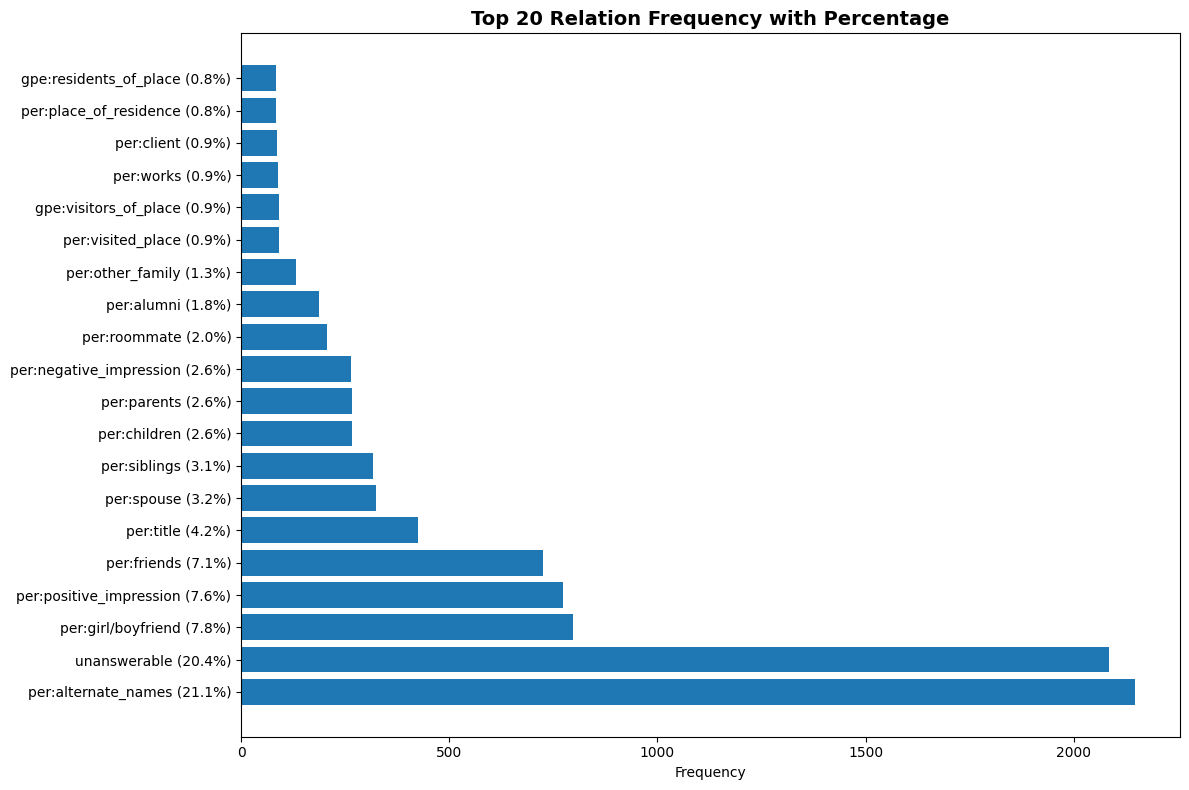

In [ ]:
plt.figure(figsize=(12, 8))
top_20_relations = dict(relation_counts.most_common(20))

# Calculate total instances for percentage calculation
total_instances = sum(relation_counts.values())

# Create labels with percentages
labels = []
for relation, count in top_20_relations.items():
    percentage = (count / total_instances) * 100
    labels.append(f"{relation} ({percentage:.1f}%)")

plt.barh(labels, list(top_20_relations.values()))
plt.title('Top 20 Relation Frequency with Percentage', fontsize=14, fontweight='bold')
plt.xlabel('Frequency')
plt.tick_params(axis='y', labelsize=10)
plt.tight_layout()
plt.show()

#### Plot 2: Distribution by Category


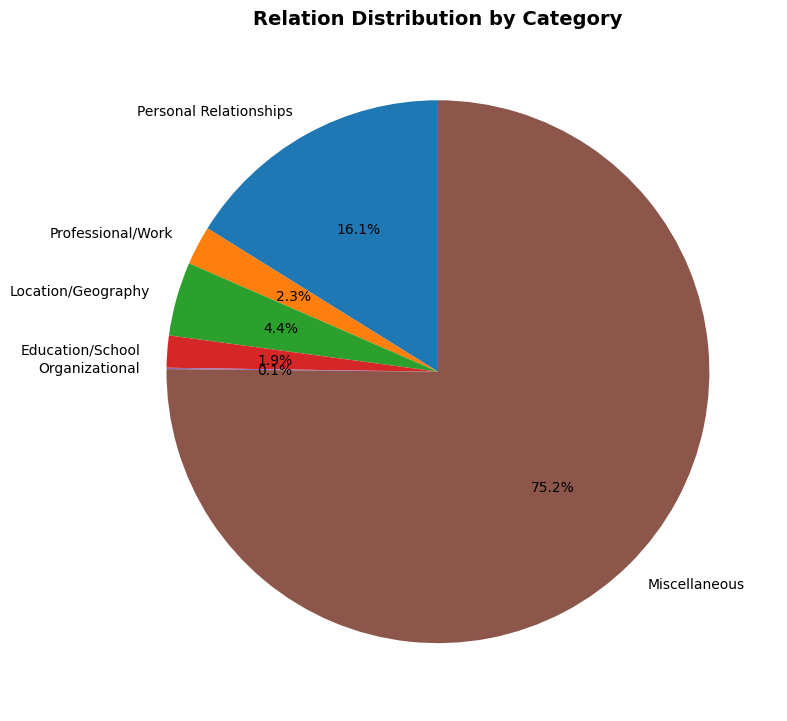

In [ ]:
plt.figure(figsize=(8, 8))
category_counts = {}
for category, relations in relation_categories.items():
    if relations:
        category_counts[category] = sum(relation_counts[rel] for rel in relations if rel in relation_counts)

plt.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%', startangle=90)
plt.title('Relation Distribution by Category', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


#### Plot 3: Distribution of Relation Frequencies


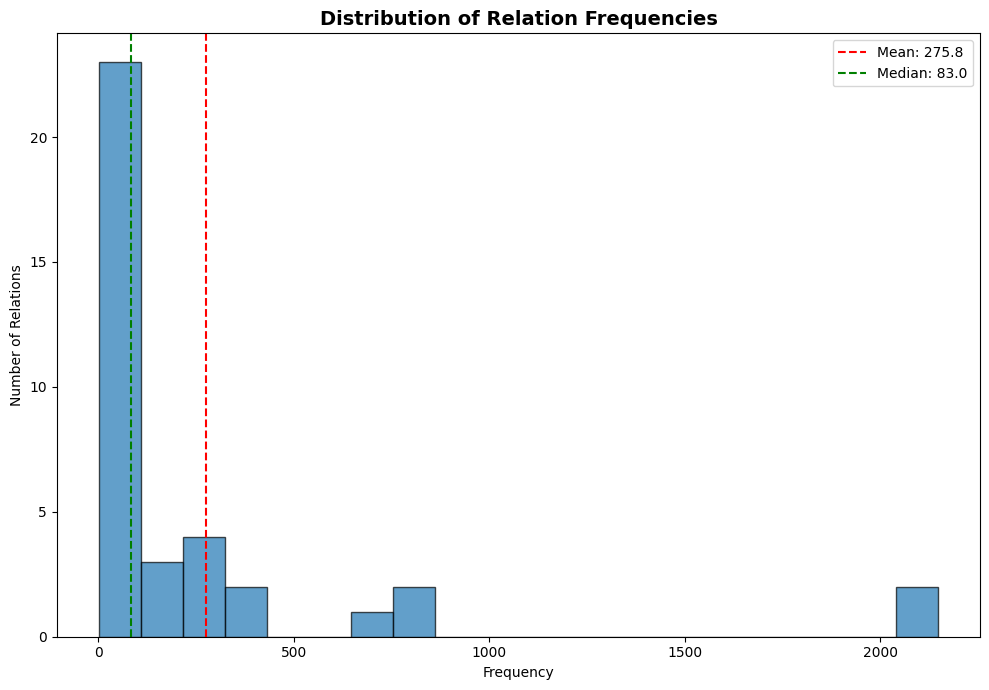

In [ ]:
plt.figure(figsize=(10, 7))
frequencies = list(relation_counts.values())
plt.hist(frequencies, bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Relation Frequencies', fontsize=14, fontweight='bold')
plt.xlabel('Frequency')
plt.ylabel('Number of Relations')
plt.axvline(np.mean(frequencies), color='red', linestyle='--', label=f'Mean: {np.mean(frequencies):.1f}')
plt.axvline(np.median(frequencies), color='green', linestyle='--', label=f'Median: {np.median(frequencies):.1f}')
plt.legend()
plt.tight_layout()
plt.show()


#### Dataset Distribution for Top 10 Relations

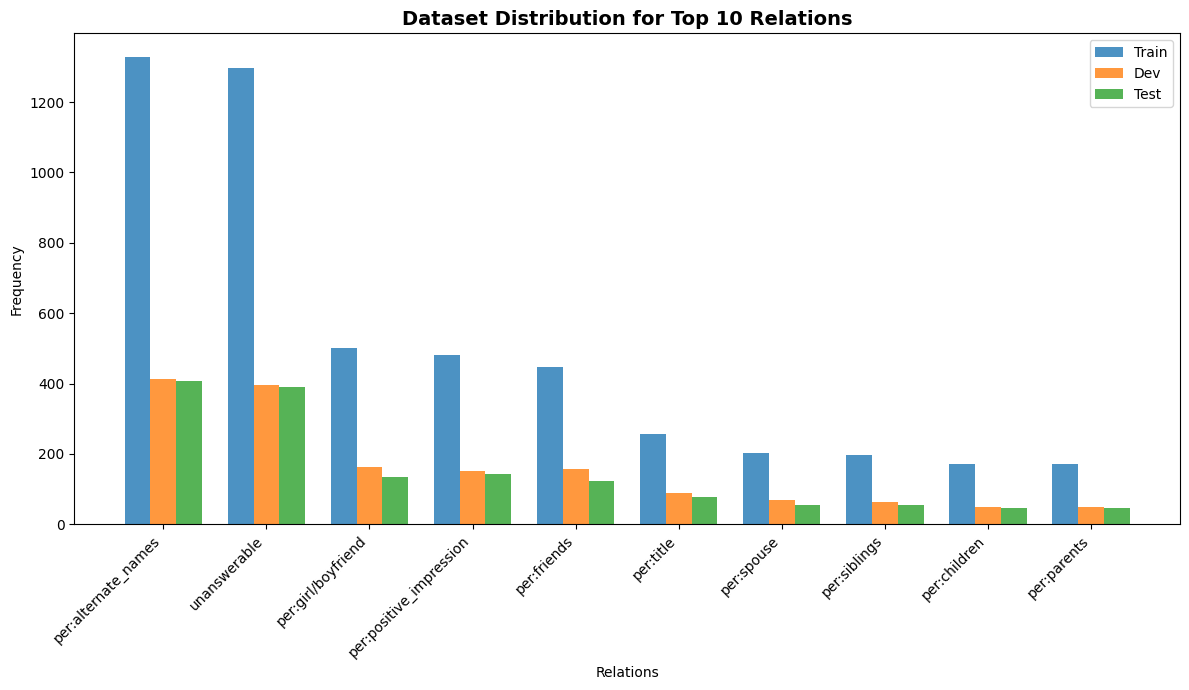

In [ ]:
plt.figure(figsize=(12, 7))
top_10_relations = [rel for rel, _ in relation_counts.most_common(10)]
train_counts = [dataset_relation_counts['train'][rel] for rel in top_10_relations]
dev_counts = [dataset_relation_counts['dev'][rel] for rel in top_10_relations]
test_counts = [dataset_relation_counts['test'][rel] for rel in top_10_relations]

x = np.arange(len(top_10_relations))
width = 0.25

plt.bar(x - width, train_counts, width, label='Train', alpha=0.8)
plt.bar(x, dev_counts, width, label='Dev', alpha=0.8)
plt.bar(x + width, test_counts, width, label='Test', alpha=0.8)

plt.title('Dataset Distribution for Top 10 Relations', fontsize=14, fontweight='bold')
plt.xlabel('Relations')
plt.ylabel('Frequency')
plt.xticks(x, top_10_relations, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


##  Statistical Summary

In [ ]:
print("\n" + "="*60)
print("STATISTICAL SUMMARY")
print("="*60)

total_instances = sum(relation_counts.values())
print(f"Total relation instances: {total_instances:,}")
print(f"Number of unique relation types: {len(unique_relations)}")
print(f"Average instances per relation type: {total_instances/len(unique_relations):.2f}")
print(f"Most frequent relation: {relation_counts.most_common(1)[0][0]} ({relation_counts.most_common(1)[0][1]} instances)")
print(f"Least frequent relation: {relation_counts.most_common()[-1][0]} ({relation_counts.most_common()[-1][1]} instances)")

# Calculate distribution statistics
frequencies = list(relation_counts.values())
print(f"\nFrequency Distribution Statistics:")
print(f"  Mean frequency: {np.mean(frequencies):.2f}")
print(f"  Median frequency: {np.median(frequencies):.2f}")
print(f"  Standard deviation: {np.std(frequencies):.2f}")
print(f"  Min frequency: {min(frequencies)}")
print(f"  Max frequency: {max(frequencies)}")



STATISTICAL SUMMARY
Total relation instances: 10,203
Number of unique relation types: 37
Average instances per relation type: 275.76
Most frequent relation: per:alternate_names (2148 instances)
Least frequent relation: gpe:births_in_place (1 instances)

Frequency Distribution Statistics:
  Mean frequency: 275.76
  Median frequency: 83.00
  Standard deviation: 484.77
  Min frequency: 1
  Max frequency: 2148


## Detailed DataFrame for further analysis

In [ ]:
relation_analysis_df = pd.DataFrame([
    {
        'relation': relation,
        'total_count': relation_counts[relation],
        'train_count': dataset_relation_counts['train'][relation],
        'dev_count': dataset_relation_counts['dev'][relation],
        'test_count': dataset_relation_counts['test'][relation],
        'percentage': (relation_counts[relation] / total_instances) * 100,
        'category': next((cat for cat, rels in relation_categories.items() if relation in rels), 'Unknown')
    }
    for relation in sorted_relations
])

# Sort by total count (descending)
relation_analysis_df = relation_analysis_df.sort_values('total_count', ascending=False).reset_index(drop=True)

print("\n" + "="*60)
print("DETAILED RELATION ANALYSIS TABLE")
print("="*60)
print(relation_analysis_df.to_string(index=False))

# saving analysis
relation_analysis_df.to_csv(f"{data_path}/relation_analysis.csv", index=False)


DETAILED RELATION ANALYSIS TABLE
                 relation  total_count  train_count  dev_count  test_count  percentage               category
      per:alternate_names         2148         1329        413         406   21.052632          Miscellaneous
             unanswerable         2084         1298        395         391   20.425365          Miscellaneous
       per:girl/boyfriend          798          502        162         134    7.821229          Miscellaneous
  per:positive_impression          774          481        151         142    7.586004          Miscellaneous
              per:friends          726          448        156         122    7.115554 Personal Relationships
                per:title          425          258         89          78    4.165442          Miscellaneous
               per:spouse          324          202         68          54    3.175537          Miscellaneous
             per:siblings          316          196         64          56    3.097128

## Analyze dialogue structure and relation positioning


In [ ]:
def analyze_dialogue_structure(data, dataset_name):
    """Analyze how relations are embedded within dialogue structure"""

    analysis = {
        'dataset_name': dataset_name,
        'dialogue_lengths': [],
        'relation_positions': [],  # Which turns contain relation evidence
        'trigger_positions': [],   # Position of trigger words
        'multi_turn_relations': 0,  # Relations spanning multiple turns
        'single_turn_relations': 0,
        'turns_with_relations': Counter(),
        'dialogue_patterns': []
    }

    for dialogue_idx, dialogue in enumerate(data):
        turns = dialogue[0]
        instances = dialogue[1]

        dialogue_length = len(turns)
        analysis['dialogue_lengths'].append(dialogue_length)

        # Analyze each relation instance
        for instance in instances:
            x_arg = instance['x'].lower()
            y_arg = instance['y'].lower()
            triggers = [t.lower() for t in instance['t']]

            # Find which turns contain the arguments and triggers
            turns_with_x = []
            turns_with_y = []
            turns_with_triggers = []

            for turn_idx, turn in enumerate(turns):
                turn_lower = turn.lower()

                if x_arg in turn_lower:
                    turns_with_x.append(turn_idx)
                if y_arg in turn_lower:
                    turns_with_y.append(turn_idx)

                for trigger in triggers:
                    if trigger in turn_lower:
                        turns_with_triggers.append(turn_idx)

            # Determine if relation spans multiple turns
            all_relevant_turns = set(turns_with_x + turns_with_y + turns_with_triggers)
            if len(all_relevant_turns) > 1:
                analysis['multi_turn_relations'] += 1
            else:
                analysis['single_turn_relations'] += 1

            # Store turn positions for analysis
            analysis['relation_positions'].extend(all_relevant_turns)
            analysis['trigger_positions'].extend(turns_with_triggers)

            # Count which turns (relative position) contain relations
            for turn_pos in all_relevant_turns:
                relative_pos = turn_pos / max(1, dialogue_length - 1)  # Normalize to 0-1
                analysis['turns_with_relations'][round(relative_pos, 1)] += 1

    return analysis

# Run analysis for all datasets
print("Analyzing dialogue structure and relation embedding...")
train_structure = analyze_dialogue_structure(train_data, 'Train')
dev_structure = analyze_dialogue_structure(dev_data, 'Dev')
test_structure = analyze_dialogue_structure(test_data, 'Test')

Analyzing dialogue structure and relation embedding...


## Display dialogue structure statistics


In [ ]:
def display_structure_stats(analysis):
    """Display dialogue structure statistics"""
    print(f"\n=== {analysis['dataset_name']} Dataset Structure Analysis ===")
    print(f"Average dialogue length: {np.mean(analysis['dialogue_lengths']):.2f} turns")
    print(f"Min dialogue length: {min(analysis['dialogue_lengths'])} turns")
    print(f"Max dialogue length: {max(analysis['dialogue_lengths'])} turns")

    total_relations = analysis['multi_turn_relations'] + analysis['single_turn_relations']
    print(f"\nRelation Span Analysis:")
    print(f"  Single-turn relations: {analysis['single_turn_relations']} ({analysis['single_turn_relations']/total_relations*100:.1f}%)")
    print(f"  Multi-turn relations: {analysis['multi_turn_relations']} ({analysis['multi_turn_relations']/total_relations*100:.1f}%)")

for analysis in [train_structure, dev_structure, test_structure]:
    display_structure_stats(analysis)


=== Train Dataset Structure Analysis ===
Average dialogue length: 13.07 turns
Min dialogue length: 1 turns
Max dialogue length: 40 turns

Relation Span Analysis:
  Single-turn relations: 48 (0.8%)
  Multi-turn relations: 5949 (99.2%)

=== Dev Dataset Structure Analysis ===
Average dialogue length: 13.09 turns
Min dialogue length: 1 turns
Max dialogue length: 40 turns

Relation Span Analysis:
  Single-turn relations: 18 (0.9%)
  Multi-turn relations: 1896 (99.1%)

=== Test Dataset Structure Analysis ===
Average dialogue length: 12.38 turns
Min dialogue length: 1 turns
Max dialogue length: 42 turns

Relation Span Analysis:
  Single-turn relations: 29 (1.6%)
  Multi-turn relations: 1833 (98.4%)


## Analyze conversational patterns and contexts


In [ ]:
def analyze_conversational_patterns(data, num_examples=5):
    """Analyze how relations appear in conversational context"""

    patterns = {
        'relation_contexts': [],
        'trigger_contexts': [],
        'speaker_patterns': [],
        'question_answer_relations': [],
        'narrative_relations': [],
        'direct_mentions': [],
        'implicit_relations': []
    }

    for dialogue_idx, dialogue in enumerate(data[:100]):  # Analyze first 100 dialogues
        turns = dialogue[0]
        instances = dialogue[1]

        for instance in instances:
            x_arg = instance['x']
            y_arg = instance['y']
            relations = instance['r']
            triggers = instance['t']

            # Find the context where this relation appears
            full_dialogue = ' '.join(turns)

            # Store examples of different patterns
            context_info = {
                'dialogue_idx': dialogue_idx,
                'x': x_arg,
                'y': y_arg,
                'relations': relations,
                'triggers': triggers,
                'dialogue': turns,
                'full_text': full_dialogue
            }

            patterns['relation_contexts'].append(context_info)

            # Analyze trigger word contexts
            for trigger in triggers:
                trigger_context = extract_trigger_context(turns, trigger)
                if trigger_context:
                    patterns['trigger_contexts'].append({
                        'trigger': trigger,
                        'context': trigger_context,
                        'relation': relations[0] if relations else 'unknown'
                    })

    return patterns

def extract_trigger_context(turns, trigger, window=30):
    """Extract context around trigger words"""
    full_text = ' '.join(turns)
    trigger_lower = trigger.lower()
    text_lower = full_text.lower()

    # Find trigger position
    pos = text_lower.find(trigger_lower)
    if pos != -1:
        start = max(0, pos - window)
        end = min(len(full_text), pos + len(trigger) + window)
        context = full_text[start:end]
        return context.strip()
    return None

print("\nAnalyzing conversational patterns...")
train_patterns = analyze_conversational_patterns(train_data)


Analyzing conversational patterns...


## Display example dialogues with relation annotations


In [ ]:
def display_annotated_examples(data, num_examples=1):
    """Display example dialogues with relation annotations"""

    print(f"\n{'='*80}")
    print("EXAMPLE DIALOGUES WITH RELATION ANNOTATIONS")
    print('='*80)

    # Select random indices for examples
    import random
    dialogue_indices = random.sample(range(len(data)), min(num_examples, len(data)))


    for dialogue_idx in dialogue_indices:
        dialogue = data[dialogue_idx]
        turns = dialogue[0]
        instances = dialogue[1]

        print(f"\n--- Dialogue {dialogue_idx + 1} ---")
        print(f"Turns: {len(turns)} | Relations: {len(instances)}")

        # Display dialogue turns
        print("\nDialogue:")
        for turn_idx, turn in enumerate(turns):
            print(f"  Turn {turn_idx + 1}: {turn}")

        # Display relations
        print(f"\nRelations found in this dialogue:")
        for inst_idx, instance in enumerate(instances):
            print(f"  Relation {inst_idx + 1}:")
            print(f"    Arguments: '{instance['x']}' → '{instance['y']}'")
            print(f"    Types: {instance['x_type']} → {instance['y_type']}")
            print(f"    Relations: {', '.join(instance['r'])}")
            print(f"    Triggers: {', '.join(instance['t'])}")

            # Highlight where arguments appear in dialogue
            x_turns = []
            y_turns = []
            for turn_idx, turn in enumerate(turns):
                if instance['x'].lower() in turn.lower():
                    x_turns.append(turn_idx + 1)
                if instance['y'].lower() in turn.lower():
                    y_turns.append(turn_idx + 1)

            print(f"    '{instance['x']}' appears in turns: {x_turns}")
            print(f"    '{instance['y']}' appears in turns: {y_turns}")

        print("-" * 50)

# Display examples
display_annotated_examples(train_data, 1)


EXAMPLE DIALOGUES WITH RELATION ANNOTATIONS

--- Dialogue 42 ---
Turns: 13 | Relations: 9

Dialogue:
  Turn 1: Speaker 1: Gotta go. I miss you too, I love you, but it's getting real late now
  Turn 2: Speaker 2: Hey Ma. Listen, I made the appointment with Dr. Bazida, and... Excuse me? Did you know this isn't Ma?
  Turn 3: Speaker 1: Her name's Ronni. She's a pet mortician.
  Turn 4: Speaker 2: Sure. So how long you been...
  Turn 5: Speaker 1: Remember when you were a little kid, I used to take you to the navy yard and show you the big ships?
  Turn 6: Speaker 2: Since then?!
  Turn 7: Speaker 1: No, it's only been six years. I just wanted to put a nice memory in your head so you'd know that I wasn't always such a terrible guy. ...Joe. Y'ever been in love?
  Turn 8: Speaker 2: ...I d'know.
  Turn 9: Speaker 1: Then y'haven't. You're burning your tomatoes.
  Turn 10: Speaker 2: You're one to talk.
  Turn 11: Speaker 1: Joe, your dad's in love big time. And the worst part of it is, it's

## Analyze trigger word patterns and contexts


In [ ]:
def analyze_trigger_patterns(patterns):
    """Analyze trigger word usage patterns"""

    trigger_stats = Counter()
    trigger_relations = defaultdict(list)
    context_lengths = []

    for context_info in patterns['trigger_contexts']:
        trigger = context_info['trigger']
        relation = context_info['relation']
        context = context_info['context']

        trigger_stats[trigger] += 1
        trigger_relations[trigger].append(relation)
        context_lengths.append(len(context.split()))

    print(f"\n{'='*60}")
    print("TRIGGER WORD ANALYSIS")
    print('='*60)

    print(f"Total unique triggers: {len(trigger_stats)}")
    print(f"Average context length: {np.mean(context_lengths):.1f} words")

    print(f"\nMost common trigger words:")
    for trigger, count in trigger_stats.most_common(20):
        relations = set(trigger_relations[trigger])
        print(f"  '{trigger}': {count} times → relations: {', '.join(list(relations)[:3])}{'...' if len(relations) > 3 else ''}")

    return trigger_stats, trigger_relations

trigger_stats, trigger_relations = analyze_trigger_patterns(train_patterns)


TRIGGER WORD ANALYSIS
Total unique triggers: 96
Average context length: 9.0 words

Most common trigger words:
  '': 360 times → relations: per:neighbor, per:works, per:dates...
  'friend': 18 times → relations: per:friends, per:positive_impression
  'friends': 12 times → relations: per:friends, per:positive_impression, per:roommate
  'love': 11 times → relations: per:spouse, per:friends, per:positive_impression...
  'wife': 10 times → relations: per:spouse
  'sister': 10 times → relations: per:siblings
  'brother': 8 times → relations: per:siblings
  'dad': 6 times → relations: per:parents, per:children
  'boyfriend': 6 times → relations: per:friends, per:girl/boyfriend
  'leave': 4 times → relations: per:place_of_residence, org:employees_or_members, gpe:residents_of_place...
  'baby daughter': 4 times → relations: per:parents, per:children
  'mother': 4 times → relations: per:parents, per:children
  'mom': 4 times → relations: per:parents, per:children
  'son': 4 times → relations: p

## Visualize conversational patterns

#### Dialogue length distribution


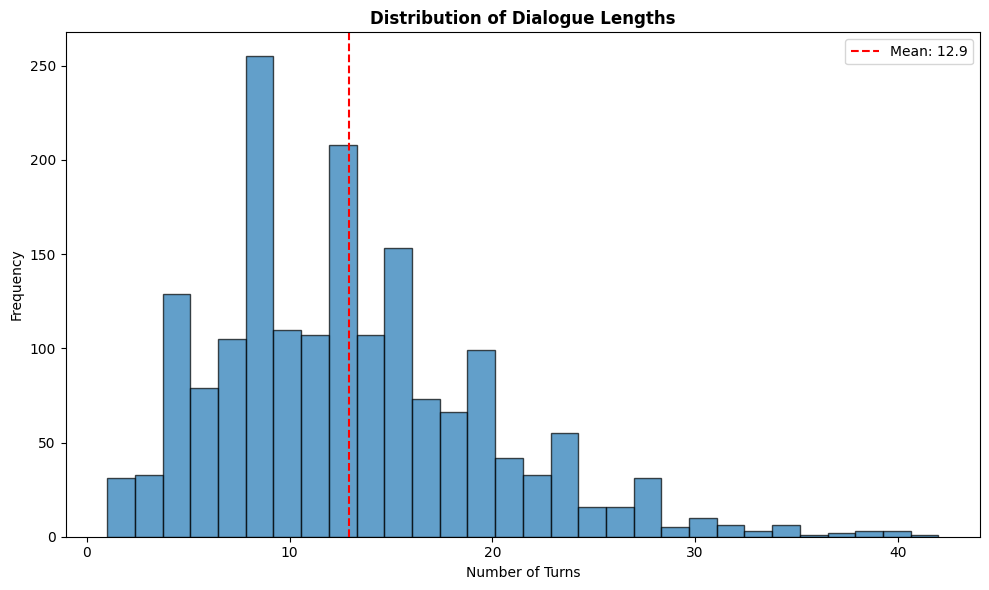

In [ ]:
plt.figure(figsize=(10, 6))
all_lengths = train_structure['dialogue_lengths'] + dev_structure['dialogue_lengths'] + test_structure['dialogue_lengths']
plt.hist(all_lengths, bins=30, alpha=0.7, edgecolor='black')
plt.title('Distribution of Dialogue Lengths', fontweight='bold')
plt.xlabel('Number of Turns')
plt.ylabel('Frequency')
plt.axvline(np.mean(all_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(all_lengths):.1f}')
plt.legend()
plt.tight_layout()
plt.show()


#### Single vs Multi-turn relations


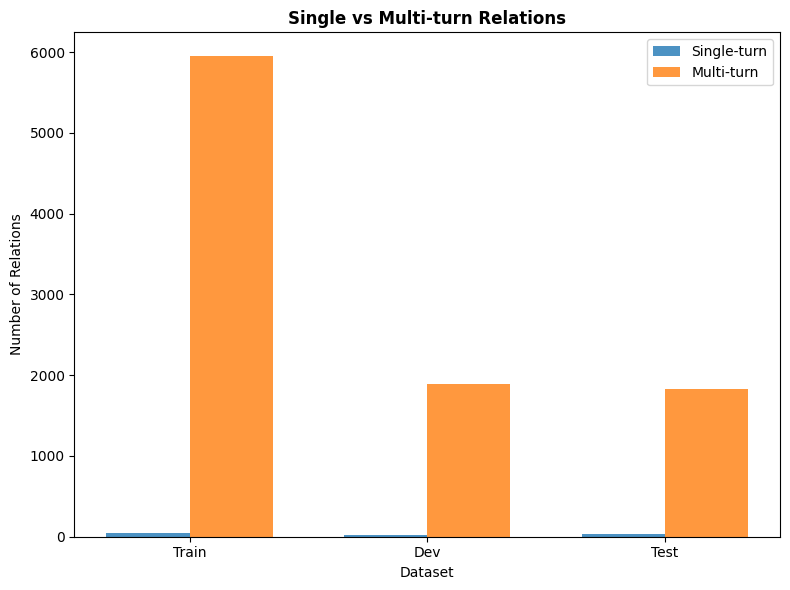

In [ ]:
plt.figure(figsize=(8, 6))
datasets = ['Train', 'Dev', 'Test']
single_turn = [train_structure['single_turn_relations'], dev_structure['single_turn_relations'], test_structure['single_turn_relations']]
multi_turn = [train_structure['multi_turn_relations'], dev_structure['multi_turn_relations'], test_structure['multi_turn_relations']]

x = np.arange(len(datasets))
width = 0.35

plt.bar(x - width/2, single_turn, width, label='Single-turn', alpha=0.8)
plt.bar(x + width/2, multi_turn, width, label='Multi-turn', alpha=0.8)
plt.title('Single vs Multi-turn Relations', fontweight='bold')
plt.xlabel('Dataset')
plt.ylabel('Number of Relations')
plt.xticks(x, datasets)
plt.legend()
plt.tight_layout()
plt.show()


#### Relation Distribution by Turn Position


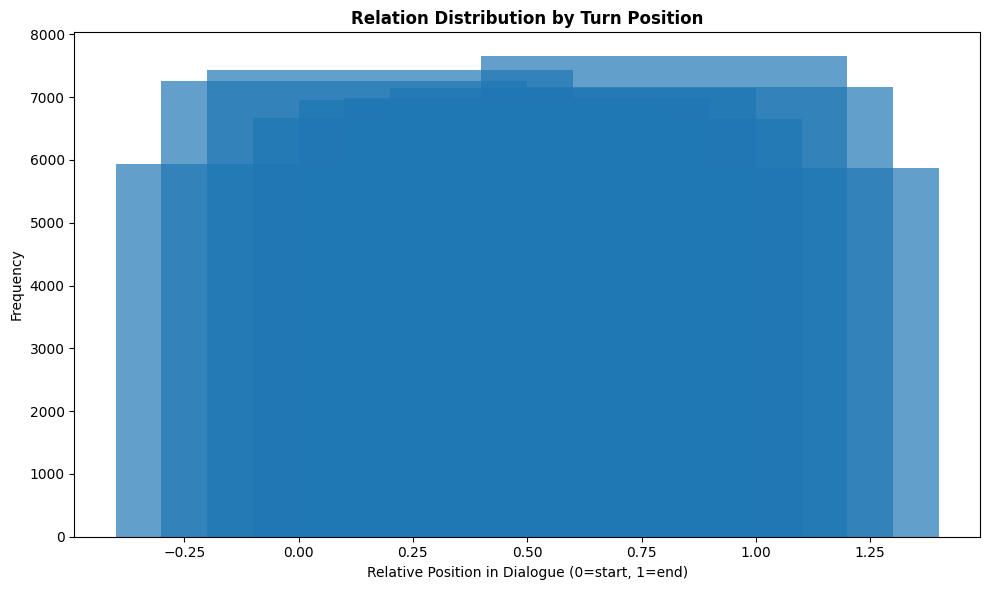

In [ ]:
plt.figure(figsize=(10, 6))
turn_positions = train_structure['turns_with_relations']
positions = sorted(turn_positions.keys())
counts = [turn_positions[pos] for pos in positions]

plt.bar(positions, counts, alpha=0.7)
plt.title('Relation Distribution by Turn Position', fontweight='bold')
plt.xlabel('Relative Position in Dialogue (0=start, 1=end)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


#### Most Frequent Trigger Words


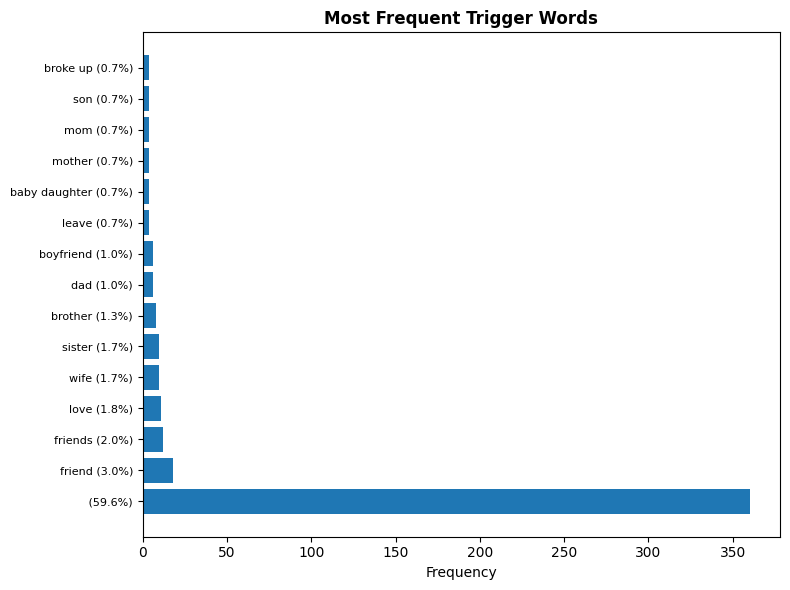

In [ ]:
plt.figure(figsize=(8, 6))
top_triggers = dict(trigger_stats.most_common(15))

# Calculate total trigger instances for percentage
total_triggers_count = sum(trigger_stats.values())

# Create labels with percentages
labels = []
for trigger, count in top_triggers.items():
    percentage = (count / total_triggers_count) * 100 if total_triggers_count > 0 else 0
    labels.append(f"{trigger} ({percentage:.1f}%)")


plt.barh(labels, list(top_triggers.values()))
plt.title('Most Frequent Trigger Words', fontweight='bold')
plt.xlabel('Frequency')
plt.tick_params(axis='y', labelsize=8)
plt.tight_layout()
plt.show()

#### Relations per Dialogue Distribution


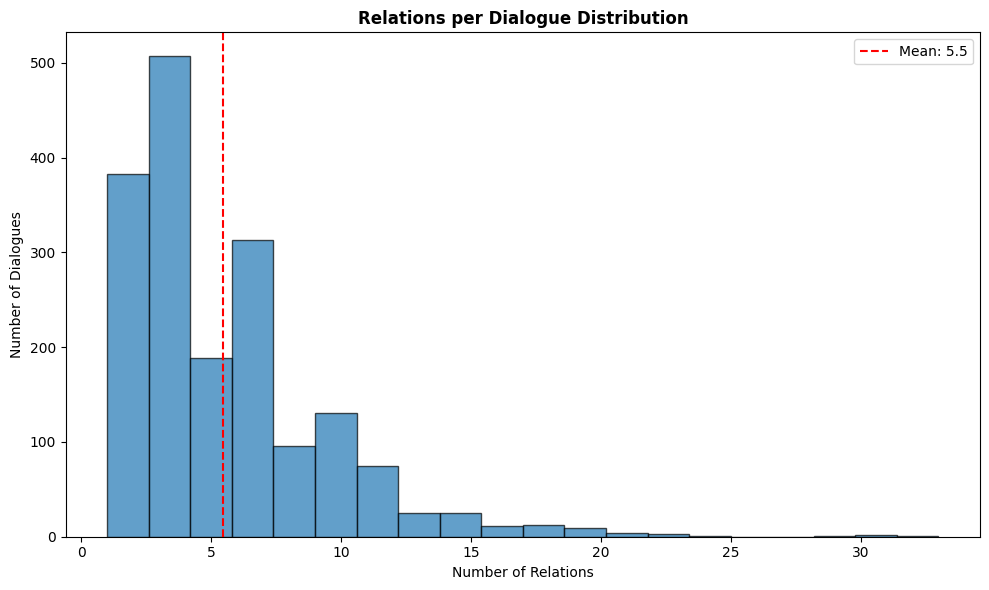

In [ ]:
plt.figure(figsize=(10, 6))
relation_counts_per_dialogue = [len(dialogue[1]) for dialogue in train_data + dev_data + test_data]

plt.hist(relation_counts_per_dialogue, bins=20, alpha=0.7, edgecolor='black')
plt.title('Relations per Dialogue Distribution', fontweight='bold')
plt.xlabel('Number of Relations')
plt.ylabel('Number of Dialogues')
plt.axvline(np.mean(relation_counts_per_dialogue), color='red', linestyle='--',
            label=f'Mean: {np.mean(relation_counts_per_dialogue):.1f}')
plt.legend()
plt.tight_layout()
plt.show()


## Analyze specific conversational phenomena


In [ ]:
def analyze_conversational_phenomena(data, sample_size=50):
    """Analyze specific conversational phenomena"""

    phenomena = {
        'questions_leading_to_relations': [],
        'narrative_relations': [],
        'dialogue_based_relations': [],
        'context_dependent_relations': [],
        'coreference_relations': []
    }

    question_words = ['what', 'who', 'where', 'when', 'why', 'how', 'which', 'whose']

    for dialogue_idx, dialogue in enumerate(data[:sample_size]):
        turns = dialogue[0]
        instances = dialogue[1]

        for turn_idx, turn in enumerate(turns):
            turn_lower = turn.lower().strip()

            # Check for questions
            is_question = turn_lower.endswith('?') or any(turn_lower.startswith(qw) for qw in question_words)

            if is_question:
                # Check if next turns contain relation information
                for inst in instances:
                    # Check if relation arguments appear in subsequent turns
                    for next_turn_idx in range(turn_idx + 1, min(turn_idx + 3, len(turns))):
                        if next_turn_idx < len(turns):
                            next_turn = turns[next_turn_idx].lower()
                            if (inst['x'].lower() in next_turn or inst['y'].lower() in next_turn):
                                phenomena['questions_leading_to_relations'].append({
                                    'question': turn,
                                    'answer_turn': turns[next_turn_idx],
                                    'relation': inst['r'][0] if inst['r'] else 'unknown',
                                    'arguments': f"{inst['x']} → {inst['y']}"
                                })

    return phenomena

print("\nAnalyzing conversational phenomena...")
phenomena = analyze_conversational_phenomena(train_data)

print(f"\nFound {len(phenomena['questions_leading_to_relations'])} question-answer relation patterns")

# Show some examples
if phenomena['questions_leading_to_relations']:
    print("\nExample Question-Answer Relation Patterns:")
    for i, example in enumerate(phenomena['questions_leading_to_relations'][:3]):
        print(f"\nExample {i+1}:")
        print(f"  Question: {example['question']}")
        print(f"  Answer: {example['answer_turn']}")
        print(f"  Relation: {example['relation']} ({example['arguments']})")


Analyzing conversational phenomena...

Found 890 question-answer relation patterns

Example Question-Answer Relation Patterns:

Example 1:
  Question: Speaker 1: Who is he?
  Answer: Speaker 2: Some guy, Tom Gordon.
  Relation: per:alternate_names (Speaker 2 → Chandler Bing)

Example 2:
  Question: Speaker 1: Who is he?
  Answer: Speaker 2: Some guy, Tom Gordon.
  Relation: per:alumni (Speaker 2 → Speaker 4)

Example 3:
  Question: Speaker 1: Who is he?
  Answer: Speaker 2: Some guy, Tom Gordon.
  Relation: per:alternate_names (Speaker 4 → Tom Gordon)


## Create summary insights


In [ ]:
print(f"\n{'='*80}")
print("CONVERSATIONAL CONTEXT ANALYSIS SUMMARY")
print('='*80)

total_dialogues = len(train_data) + len(dev_data) + len(test_data)
total_relations = sum(len(d[1]) for d in train_data + dev_data + test_data)
avg_dialogue_length = np.mean(all_lengths)

print(f"Dataset Overview:")
print(f"  Total dialogues: {total_dialogues}")
print(f"  Total relations: {total_relations}")
print(f"  Average dialogue length: {avg_dialogue_length:.1f} turns")
print(f"  Average relations per dialogue: {total_relations/total_dialogues:.2f}")

# Multi-turn analysis
total_single = sum([train_structure['single_turn_relations'], dev_structure['single_turn_relations'], test_structure['single_turn_relations']])
total_multi = sum([train_structure['multi_turn_relations'], dev_structure['multi_turn_relations'], test_structure['multi_turn_relations']])

print(f"\nRelation Span Characteristics:")
print(f"  Single-turn relations: {total_single} ({total_single/(total_single+total_multi)*100:.1f}%)")
print(f"  Multi-turn relations: {total_multi} ({total_multi/(total_single+total_multi)*100:.1f}%)")

print(f"\nTrigger Word Insights:")
print(f"  Unique trigger words: {len(trigger_stats)}")
print(f"  Most common trigger: '{trigger_stats.most_common(1)[0][0]}' ({trigger_stats.most_common(1)[0][1]} occurrences)")

print(f"\nConversational Patterns:")
print(f"  Question-answer relation patterns found: {len(phenomena['questions_leading_to_relations'])}")

print(f"\nKey Insights:")
print(f"  • {'Multi-turn' if total_multi > total_single else 'Single-turn'} relations are more common")
print(f"  • Relations are distributed across dialogue positions (not concentrated at beginning/end)")
print(f"  • Trigger words show diverse vocabulary, indicating rich conversational expression")
print(f"  • Question-answer patterns provide natural contexts for relation extraction")


CONVERSATIONAL CONTEXT ANALYSIS SUMMARY
Dataset Overview:
  Total dialogues: 1788
  Total relations: 9773
  Average dialogue length: 12.9 turns
  Average relations per dialogue: 5.47

Relation Span Characteristics:
  Single-turn relations: 95 (1.0%)
  Multi-turn relations: 9678 (99.0%)

Trigger Word Insights:
  Unique trigger words: 96
  Most common trigger: '' (360 occurrences)

Conversational Patterns:
  Question-answer relation patterns found: 890

Key Insights:
  • Multi-turn relations are more common
  • Relations are distributed across dialogue positions (not concentrated at beginning/end)
  • Trigger words show diverse vocabulary, indicating rich conversational expression
  • Question-answer patterns provide natural contexts for relation extraction
